In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.models import vgg16, VGG16_Weights
import numpy as np
import pandas as pd
from typing import Dict, Final, List, Tuple, NamedTuple, Type
from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix
import seaborn as sns

import cv2

from collections import Counter

import skimage.transform

import matplotlib.pyplot as plt

FAIL = 2  # failing die
PASS = 1  # passing die
NO_DIE = 0  # no die

Loss: Type = float
Accuracy: Type = float

class LossAcc(NamedTuple):
    loss: Loss
    accuracy: Accuracy

class TrainValLossAcc(NamedTuple):
    train: List[List[LossAcc]]
    val: List[LossAcc]


device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
print(f"Is CUDA supported by this system?{torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")

print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")


PyTorch Version:  1.13.0+cu117
Torchvision Version:  0.14.0+cu117
Is CUDA supported by this system?True
CUDA version: 11.7
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce RTX 2060


In [2]:
df_train: pd.DataFrame = pd.DataFrame.from_records(np.load('wafermap_HW3_train.npy', allow_pickle=True))

In [3]:
classes: Final[List[str]] = df_train.failureType.unique()

num_classes: Final[int] = len(classes)

num_epochs: Final[int] = 20

batch_size: Final[int] = 16

test_set_size: Final[float] = 0.30

test_set_sample_count: Final[int] = int(test_set_size * len(df_train))

test_set_actual_size: Final[float] = test_set_sample_count / len(df_train)


NO_DIE: Final[int] = 0
PASS_DIE: Final[int] = 1
FAIL_DIE: Final[int] = 2
NUM_DIE_STATES: Final[int] = 3


print("Number of classes: ", num_classes)
print("Number of epochs: ", num_epochs)
print("Batch size: ", batch_size)
print("Test set size: {:.2f}%".format(test_set_actual_size * 100))
print("Test set sample count: ", test_set_sample_count)

Number of classes:  5
Number of epochs:  20
Batch size:  16
Test set size: 30.00%
Test set sample count:  540


In [4]:
def convert_failure_type(failure_type: str) -> int:
    # Create dictionary for converting string to numeric number
    string2int: Final[Dict[str, int]] = {'Edge-Loc':0, 'Scratch':1, 'Donut':2, 'Center':3, 'Near-full':4}

    return string2int[failure_type]


def resize_wafer_map(wafer_map: np.ndarray, output_shape: tuple = (64, 64)) -> np.ndarray:
    # Final shape should be (3, 64, 64) for VGG16.
    resized = cv2.resize(wafer_map, output_shape, interpolation=cv2.INTER_NEAREST)
    ret = np.eye(NUM_DIE_STATES)[resized]
    ret = ret.transpose(2, 1, 0)
    return ret


In [5]:
class WaferDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.df.loc[idx, 'waferMap']
        img = resize_wafer_map(img) 
        img = img.astype('float32')
        img = torch.from_numpy(img)
        label = self.df.loc[idx, 'failureType']
        label = convert_failure_type(label)
        label = torch.tensor(label)
        return img, label

In [6]:
all_dataset = WaferDataset(df_train)
train_set_sample_count = len(df_train) - test_set_sample_count
train_dataset, val_dataset = random_split(all_dataset, [
                                          train_set_sample_count, test_set_sample_count], generator=torch.Generator().manual_seed(9))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


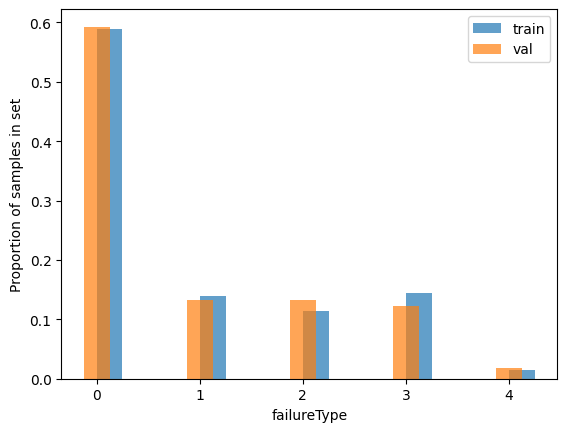

In [7]:
train_labels = pd.DataFrame(
    Counter(l.item() for _, l in train_dataset).items(),
    columns=['failureType', 'count']
)
val_labels = pd.DataFrame(
    Counter(l.item() for _, l in val_dataset).items(),
    columns=['failureType', 'count']
)
train_labels['train'] = True
train_labels['ratio'] = train_labels['count'] / (train_labels['count'].sum())
val_labels['train'] = False
val_labels['ratio'] = val_labels['count'] / (val_labels['count'].sum())
labels = pd.concat([train_labels, val_labels])

plt.bar(labels[labels['train']]['failureType'],
        labels[labels['train']]['ratio'], label='train', alpha=0.7, width=0.25, align='edge')
plt.bar(labels[~labels['train']]['failureType'],
        labels[~labels['train']]['ratio'], label='val', alpha=0.7, width=0.25)
plt.legend()
plt.xlabel('failureType')
plt.ylabel('Proportion of samples in set')
plt.show()

In [29]:
def validate(model: nn.Module, val_data: DataLoader) -> LossAcc:
    """
    Returns the loss and accuracy of the model on the validation data.
    """
    model.eval()
    with torch.no_grad():
        total_correct = 0.0
        totalLoss = 0.0
        total = 0
        # Iterate through the batches of validation data
        for i, batch in enumerate(val_data):
            # Get the data and labels from the batch
            data, labels = batch
            # Get the model's predictions for the data
            outputs = model(data)
            # Calculate the loss
            loss = nn.functional.cross_entropy(outputs, labels)
            
            # Calculate the accuracy
            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            
            # Add the loss to the total loss
            totalLoss += loss.item()
            
        # Return the average loss and accuracy over all batches.
        return LossAcc(totalLoss/len(val_data), total_correct/total)
    
def train_batch(model: nn.Module, optimizer: optim.Optimizer,
                inputs: torch.Tensor, labels: torch.Tensor) -> LossAcc:
    """
    Trains the model on a single batch of data.
    Returns the loss and accuracy of the model on the batch.
    """
    # Set model to training mode
    model.train()
    # Zero the gradients
    optimizer.zero_grad()
    # Get the model's predictions for the data
    y_pred = model(inputs)
    # Calculate the loss
    loss = nn.functional.cross_entropy(y_pred, labels)
    # Backpropagate the loss
    loss.backward()
    # Update the model's weights
    optimizer.step()
    with torch.no_grad():
        # Calculate the accuracy
        predicted = y_pred.argmax(dim=1)
        total = labels.size(0)
        total_correct = (predicted == labels).sum().item()
        # Return the loss and accuracy
        return LossAcc(loss.item(), total_correct/total)

def train_epoch(model: nn.Module, optimizer: optim.Optimizer,
                train_data: DataLoader) -> List[LossAcc]:
    """
    Trains the model on a single epoch of data.
    Returns a list of the loss and accuracy of the model on each batch.
    """
    LossAccList = []
    # Iterate through the batches of training data
    for batch in train_data:
        # Get the data and labels from the batch
        data, labels = batch
        # Train the model on the batch with `train_batch`
        batch_loss_acc = train_batch(model, optimizer, data, labels)
        # Add the loss and accuracy to the list
        LossAccList.append(batch_loss_acc)
    # Return the list of loss and accuracy
    return LossAccList

def train_loop(model: nn.Module, optimizer: optim.Optimizer,
               train_data: DataLoader, val_data: DataLoader,
               num_epochs: int = 10) -> TrainValLossAcc:
    """
    Trains the model on the training data for `num_epochs` epochs.
    Returns the loss and accuracy of the model on the training and validation data,
    taken per-batch in training and per-epoch in validation.
    """
    train_losses = []
    val_losses = []
    # Iterate through the epochs
    for epoch in range(num_epochs):
        # Train the model on the epoch with `train_epoch`
        train_loss_acc = train_epoch(model, optimizer,train_data)
        # Validate the model on the validation data
        val_loss_acc = validate(model, val_data)
        # Add the loss and accuracy to the list
        train_losses.append(train_loss_acc)
        val_losses.append(val_loss_acc)
    # Return the lists of loss and accuracy
    return TrainValLossAcc(train_losses, val_losses)

In [30]:
# Optional augmentation module
augmentation = nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(p=0.5), # Flips images left-right randomly with 50% probability
    torchvision.transforms.RandomVerticalFlip(p=0.5), # Flips images up-down randomly with 50% probability
    torchvision.transforms.RandomRotation(90), # Turns images on their sides randomly
)

In [31]:
num_classes = 5

features = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(inplace=True),
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(inplace=True)
)

num_out_features: int = int(np.prod(features(torch.rand(1, 3, 64, 64)).shape[1:]))
print("Feature out shape: ", features(torch.rand(1, 3, 64, 64)).shape, \
    ' = ', np.prod(features(torch.rand(1,3,64,64)).shape))

classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=num_out_features, out_features=512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.3, inplace=False),
    nn.Linear(in_features=512, out_features=5)
)

# Instantiate a neural network model
model = nn.Sequential(
    augmentation,
    features,
    classifier
)
model

Feature out shape:  torch.Size([1, 16, 7, 7])  =  784


Sequential(
  (0): Sequential(
    (0): RandomHorizontalFlip(p=0.5)
    (1): RandomVerticalFlip(p=0.5)
    (2): RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
  )
  (1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_feature

In [32]:
# Make the optimizer and call your training functions
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
history: TrainValLossAcc = train_loop(
    model, optimizer, train_dataloader, val_dataloader)


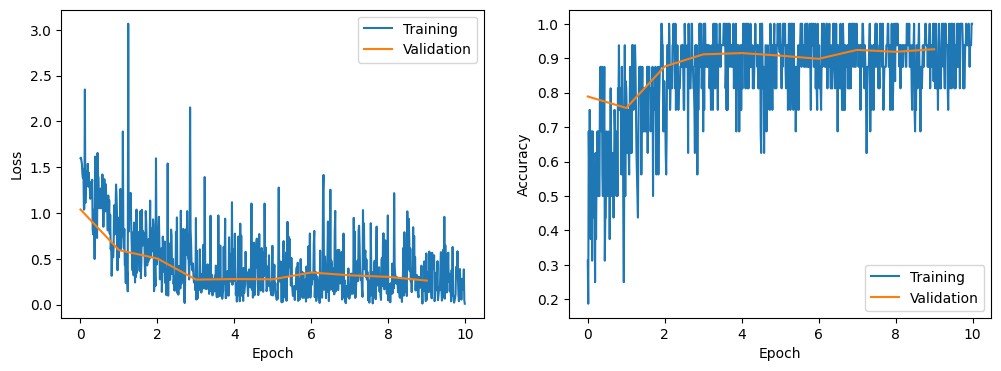

In [33]:
# Visualize your training and validation loss
training_history = pd.DataFrame.from_records(
    [loss for batch_losses in history.train for loss in batch_losses],
    columns=LossAcc._fields)
training_history['epoch'] = training_history.index / len(train_dataloader)
validation_history = pd.DataFrame.from_records(
    history.val, columns=LossAcc._fields)
validation_history['epoch'] = validation_history.index

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(training_history['epoch'],
           training_history['loss'], label='Training')
ax[0].plot(validation_history['epoch'],
           validation_history['loss'], label='Validation')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(training_history['epoch'],
           training_history['accuracy'], label='Training')
ax[1].plot(validation_history['epoch'],
           validation_history['accuracy'], label='Validation')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()


In [34]:
# Load your test data
df_test: pd.DataFrame = pd.DataFrame.from_records(
    np.load('wafermap_HW3_test.npy', allow_pickle=True))

In [35]:
# Build a test dataset and dataloader
df_test['failureType'] = 'Donut'
test_dataset = WaferDataset(df_test)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size)

traindata = validate(model, train_dataloader)
print(traindata)
testdata = validate(model, val_dataloader)
print(testdata)


LossAcc(loss=0.19325745019684487, accuracy=0.9357142857142857)
LossAcc(loss=0.23785010232206652, accuracy=0.9203703703703704)


In [36]:
output = []

def predict(model: nn.Module, val_data: DataLoader) -> list:
    model.eval()
    with torch.no_grad():
        predictions = []
        for i, batch in enumerate(val_data):
            # Get the data and labels from the batch
            data, labels = batch
            # Get the model's predictions for the data
            outputs = model(data)
            predicted = outputs.argmax(dim=1)
            predictions.extend(predicted.numpy())
        
        # Return the average loss and accuracy over all batches.
        return predictions
    

def getLabels(model: nn.Module, val_data: DataLoader) -> list:
    model.eval()
    with torch.no_grad():
        label = []
        for i, batch in enumerate(val_data):
            # Get the data and labels from the batch
            data, labels = batch
            # Get the model's predictions for the data
            label.extend(labels.numpy())

        # Return the average loss and accuracy over all batches.
        return label
    
output = predict(model, test_dataloader)

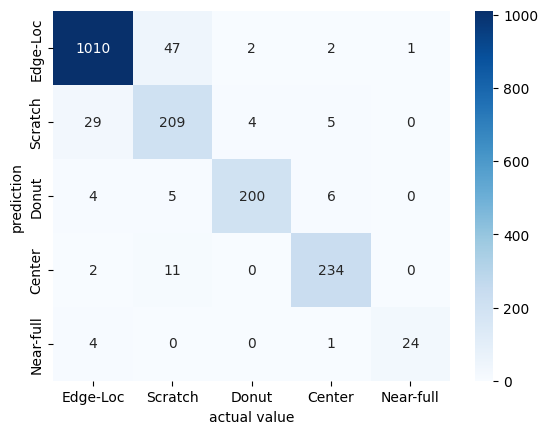

In [37]:
# Get failure types string sorted by their numerical value
tick_labels = ["Edge-Loc", "Scratch", "Donut", "Center", "Near-full"]

all_dataset = WaferDataset(df_train)
all_dataloader = DataLoader(all_dataset, batch_size=batch_size)


pred_test = predict(model, all_dataloader)
y_test = getLabels(model, all_dataloader)
cm = confusion_matrix(y_test, pred_test, labels=[0, 1, 2, 3, 4])

# plot confusion matrix using heatmap
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=tick_labels,
            yticklabels=tick_labels,
            cmap='Blues')

plt.xlabel('actual value')
plt.ylabel('prediction')

# show plot
plt.show()
